In [ ]:
# !pip install albumentations

In [2]:
import tensorflow as tf, cv2, albumentations as A, os, numpy as np, matplotlib.pyplot as plt, skimage
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from sklearn.model_selection import train_test_split
from scipy import ndimage
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
os.getcwd()

'/content'

In [6]:
os.chdir("/content/drive/MyDrive/Senior_Design/image_dataset")

### Setting up model

In [ ]:
# Define the augmentation pipeline
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2)
])

# Function to apply augmentations dynamically
def augment_on_the_fly(image, mask):
    augmented = augmentation_pipeline(image=image, mask=mask)
    return augmented['image'], augmented['mask']

In [ ]:
# Data generator for on-the-fly augmentation
def data_generator(image_paths, mask_paths, batch_size):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_images = []
            batch_masks = []
            for j in range(i, min(i + batch_size, len(image_paths))):
                # Load image and mask
                image = cv2.imread(image_paths[j], cv2.COLOR_BGR2RGB)
                mask = cv2.imread(mask_paths[j], cv2.IMREAD_GRAYSCALE)

                # Resize to match input shape
                image = cv2.resize(image, (512, 512))
                mask = cv2.resize(mask, (512, 512))

                # Apply augmentation
                aug_image, aug_mask = augment_on_the_fly(image, mask)

                # Normalize
                aug_image = aug_image / 255.0
                aug_mask = aug_mask[..., np.newaxis] / 255.0  # Add channel dimension

                batch_images.append(aug_image)
                batch_masks.append(aug_mask)

            yield np.array(batch_images, dtype=np.float32), np.array(batch_masks, dtype=np.float32)

In [ ]:
# # Define a convolutional block
# def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same'):
#     x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
#     x = BatchNormalization()(x)
#     x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
#     x = BatchNormalization()(x)
#     return x

# # Define an encoder block
# def encoder_block(inputs, filters):
#     x = conv_block(inputs, filters)
#     p = MaxPooling2D(pool_size=(2, 2))(x)
#     return x, p

# # Define a decoder block
# def decoder_block(inputs, skip_features, filters):
#     x = Conv2DTranspose(filters, kernel_size=(2, 2), strides=(2, 2), padding='same')(inputs)
#     x = concatenate([x, skip_features])
#     x = conv_block(x, filters)
#     return x

# # Define the Multi-Scale U-Net model
# def multi_scale_unet(input_shape=(512, 512, 3), num_classes=1):
#     inputs = Input(input_shape)

#     # Encoder path
#     s1, p1 = encoder_block(inputs, 64)
#     s2, p2 = encoder_block(p1, 128)
#     s3, p3 = encoder_block(p2, 256)
#     s4, p4 = encoder_block(p3, 512)

#     # Bridge
#     b1 = conv_block(p4, 1024)

#     # Decoder path
#     d1 = decoder_block(b1, s4, 512)
#     d2 = decoder_block(d1, s3, 256)
#     d3 = decoder_block(d2, s2, 128)
#     d4 = decoder_block(d3, s1, 64)

#     # Output layer
#     outputs = Conv2D(num_classes, (1, 1), activation='sigmoid' if num_classes == 1 else 'softmax')(d4)

#     # Model
#     model = Model(inputs, outputs, name="Multi-Scale-U-Net")
#     return model

# # Instantiate the model
# input_shape = (512, 512, 3)
# num_classes = 1  # Use 1 for binary segmentation, or adjust for multi-class segmentation
# model = multi_scale_unet(input_shape, num_classes)

# # Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#               loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy',
#               metrics=['accuracy'])

# # Display the model summary
# model.summary()

In [ ]:
### Lighter Model
# Define a lighter convolutional block
def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same'):
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    x = BatchNormalization()(x)
    return x

# Define an encoder block
def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    p = MaxPooling2D(pool_size=(2, 2))(x)
    return x, p

# Define a decoder block
def decoder_block(inputs, skip_features, filters):
    x = Conv2DTranspose(filters, kernel_size=(2, 2), strides=(2, 2), padding='same')(inputs)
    x = concatenate([x, skip_features])
    x = conv_block(x, filters)
    return x

# Define a lighter Multi-Scale U-Net model
def multi_scale_unet(input_shape=(512, 512, 3), num_classes=1):
    inputs = Input(input_shape)

    # Encoder path
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    # Bridge
    b1 = conv_block(p4, 512)

    # Decoder path
    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid' if num_classes == 1 else 'softmax')(d4)

    # Model
    model = Model(inputs, outputs, name="Lighter-Multi-Scale-U-Net")
    return model

# Instantiate the model
input_shape = (512, 512, 3)
num_classes = 1  # Use 1 for binary segmentation, or adjust for multi-class segmentation
model = multi_scale_unet(input_shape, num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "Lighter-Multi-Scale-U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 32)   │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 256)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 512)    │          2,048 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 3,838,497 (14.64 MB)

 Trainable params: 3,835,553 (14.63 MB)

 Non-trainable params: 2,944 (11.50 KB)

### Loading images

In [ ]:
image_prefix, mask_prefix = "original/", "mask/"
ip, mp = [image_prefix + n for n in sorted(os.listdir(image_prefix))], [mask_prefix + n for n in sorted(os.listdir(mask_prefix))]

In [ ]:
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    ip, mp, test_size=0.2, random_state=42
)


In [ ]:
batch_size = 5

train_gen = data_generator(train_image_paths, train_mask_paths, batch_size)
test_gen = data_generator(test_image_paths, test_mask_paths, batch_size)

steps_per_epoch = len(train_image_paths) // batch_size
validation_steps = len(test_image_paths) // batch_size

model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=20, validation_data=test_gen, validation_steps=validation_steps, verbose = 1)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.7228 - loss: 0.6009 - val_accuracy: 0.2884 - val_loss: 0.7028
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.8434 - loss: 0.4152 - val_accuracy: 0.3198 - val_loss: 0.7073
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - accuracy: 0.8544 - loss: 0.3880 - val_accuracy: 0.3830 - val_loss: 0.6976
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 256ms/step - accuracy: 0.8885 - loss: 0.3334 - val_accuracy: 0.4424 - val_loss: 0.6927
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - accuracy: 0.8949 - loss: 0.3023 - val_accuracy: 0.4068 - val_loss: 0.6985
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - accuracy: 0.8715 - loss: 0.3311 - val_accuracy: 0.7117 - val_loss: 0.6566
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.8927 - loss: 0.2977 - val_accuracy: 0.7391 - val_loss: 0.6388
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.8971 - loss: 0.3048 - val_accuracy: 0.72

In [ ]:
# Visualization of predictions
def visualize_predictions(model, test_images, test_masks, num_examples=3):
    predictions = model.predict(test_images)
    threshold = 0.4
    for i in range(num_examples):
        plt.figure(figsize=(12, 4))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(test_images[i])

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(test_masks[i].squeeze(), cmap='gray')

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        binary_pred_mask = (predictions[i] > threshold).astype(np.float32)
        plt.imshow(binary_pred_mask.squeeze(), cmap='gray')

        plt.show()

# Load and preprocess test data for visualization
def load_and_preprocess_test_data(image_paths, mask_paths, input_shape=(512, 512)):
    test_images = []
    test_masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        image = cv2.imread(img_path)
        image = cv2.resize(image, input_shape[:2])
        image = image / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, input_shape[:2])
        mask = mask[..., np.newaxis] / 255.0

        test_images.append(image)
        test_masks.append(mask)

    return np.array(test_images, dtype=np.float32), np.array(test_masks, dtype=np.float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


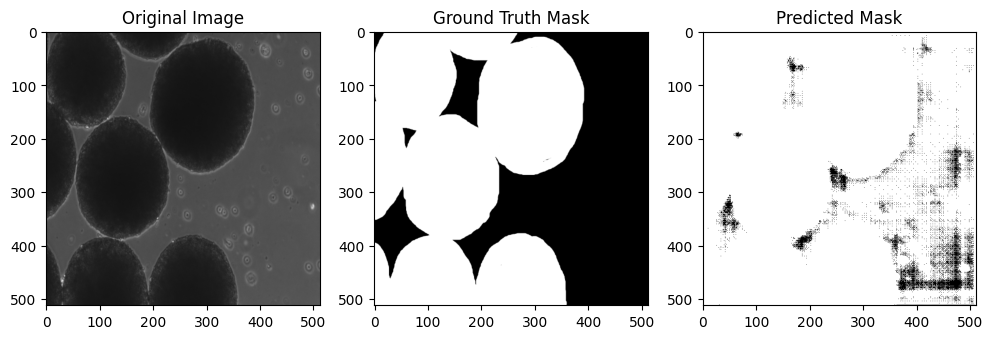

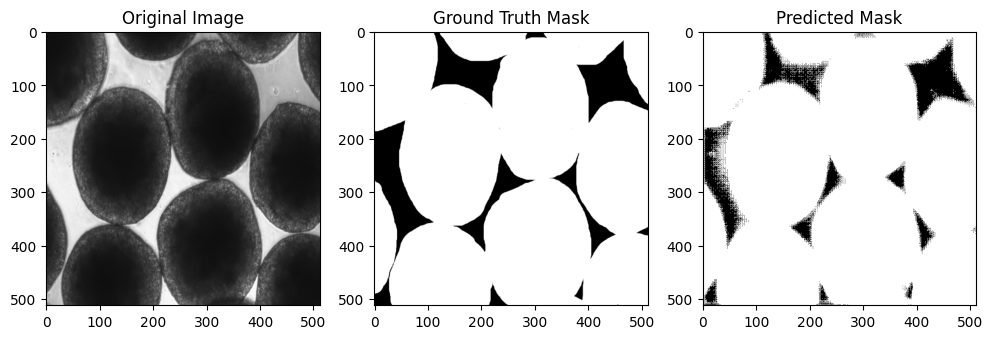

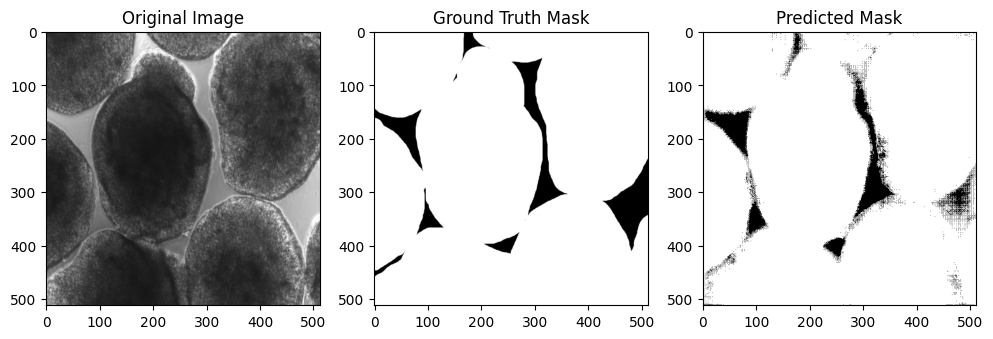

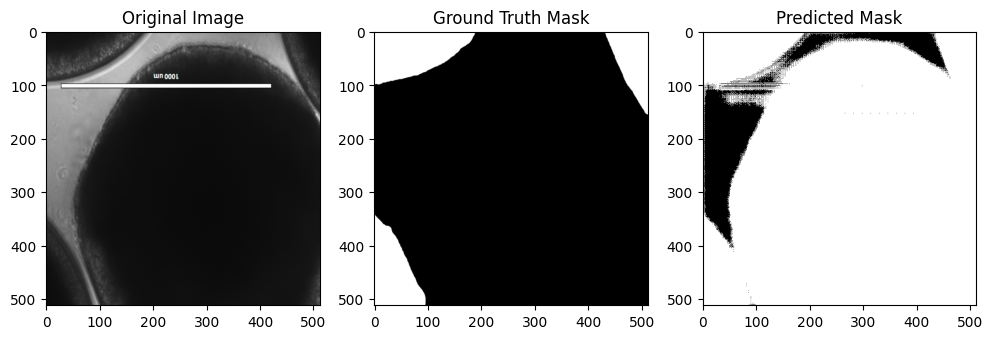

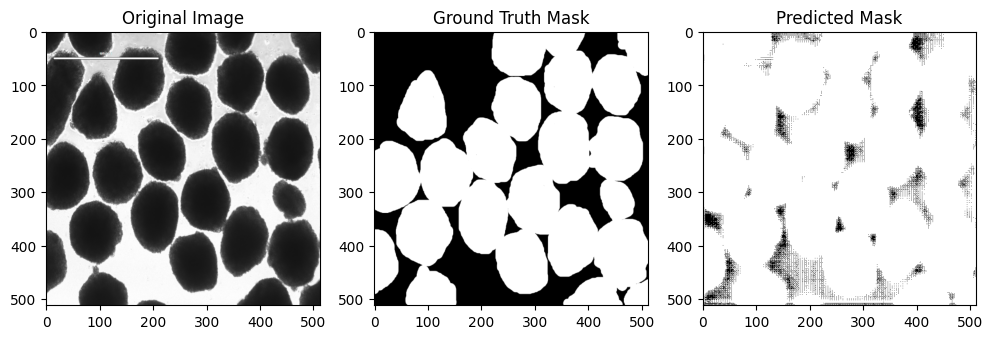

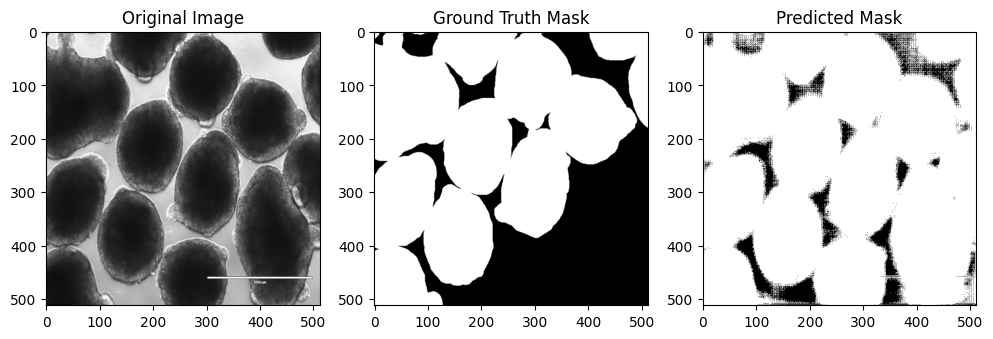

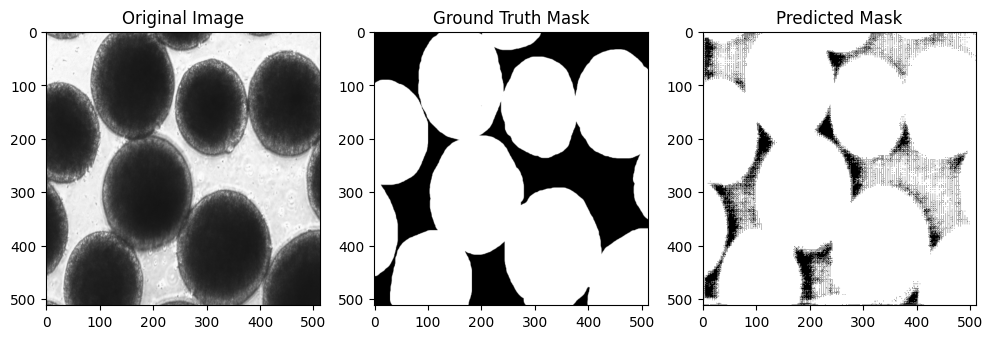

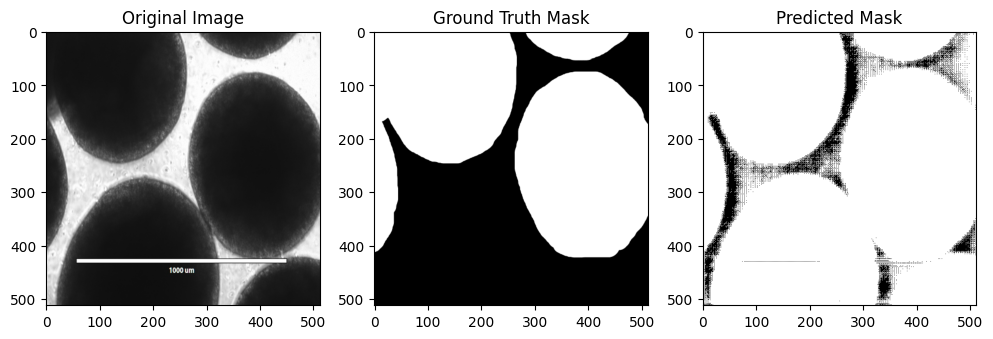

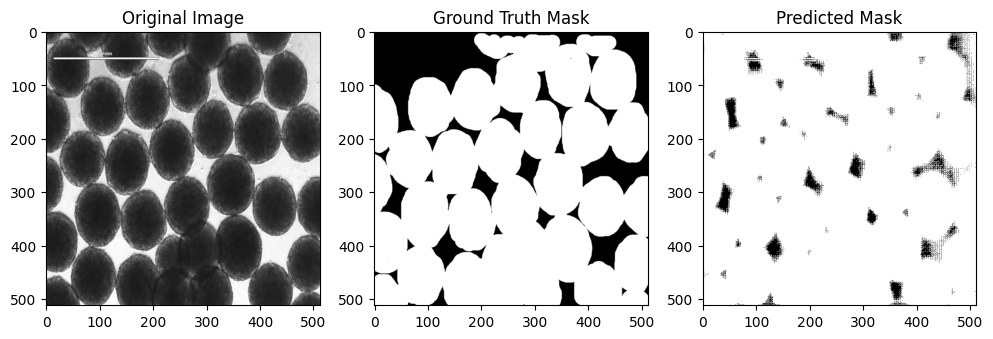

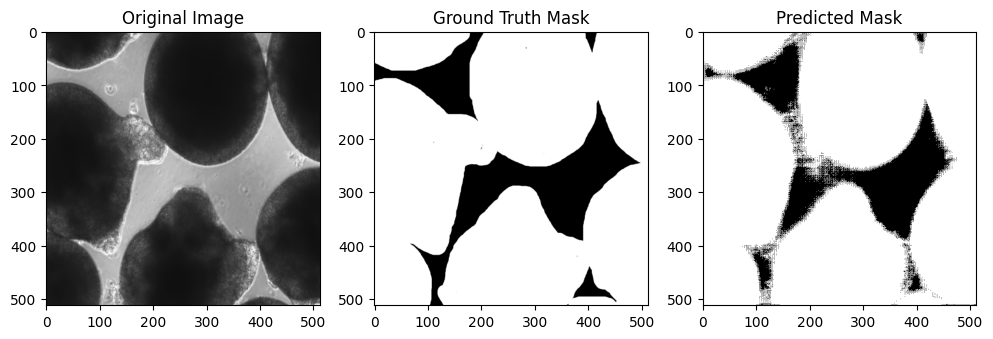

In [ ]:
# Example usage for visualization
num_examples = 10
test_images, test_masks = load_and_preprocess_test_data(test_image_paths, test_mask_paths)
visualize_predictions(model, test_images, test_masks, num_examples)

In [ ]:
model.save("../MS_Unet_Lite_1.keras")

### Separate Contours

In [7]:
def load_and_preprocess_test_data(image_paths, mask_paths, input_shape=(512, 512)):
    test_images = []
    test_masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        image = cv2.imread(img_path)
        image = cv2.resize(image, input_shape[:2])
        image = image / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, input_shape[:2])
        mask = mask[..., np.newaxis] / 255.0

        test_images.append(image)
        test_masks.append(mask)

    return np.array(test_images, dtype=np.float32), np.array(test_masks, dtype=np.float32)

In [8]:
model = load_model("../MS_Unet_Lite_1.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
image_prefix, mask_prefix = "original/", "mask/"
ip, mp = [image_prefix + n for n in sorted(os.listdir(image_prefix))], [mask_prefix + n for n in sorted(os.listdir(mask_prefix))]

In [10]:
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    ip, mp, test_size=0.2, random_state=42
)


In [11]:
test_images, test_masks = load_and_preprocess_test_data(test_image_paths, test_mask_paths)

In [12]:
pred = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step


In [13]:
# # OrganoID code
# def DetectEdges(images: np.ndarray, gaussianSigma: float,
#                 hysteresisMinimum: float, hysteresisMaximum: float,
#                 foregroundThreshold: float):
#     edgeImages = np.zeros(images.shape, dtype=bool)
#     for i in range(images.shape[0]):
#         # Reordered Canny edge detector (Sobel -> Gaussian -> Hysteresis threshold)
#         smoothEdges = skimage.filters.gaussian(skimage.filters.sobel(images[i]), gaussianSigma)
#         edges = skimage.filters.apply_hysteresis_threshold(smoothEdges, hysteresisMinimum,hysteresisMaximum)

#         foregroundMask = skimage.morphology.binary_opening(images[i] >= foregroundThreshold)
#         edgeImages[i, :, :] = np.bitwise_and(edges, foregroundMask)
#     return edgeImages

# def SeparateContours(images: np.ndarray, edges: np.ndarray, foregroundThreshold: float,
#                      gaussianSigma: float):
#     separatedImages = np.zeros(images.shape, np.uint16)
#     for i in range(images.shape[0]):

#         # Consider organoids to be present at pixels with greater than 50% detection belief.
#         foregroundMask = skimage.morphology.binary_opening(images[i] >= foregroundThreshold)

#         # Watershed algorithm is used to distinguish organoids in contact. The algorithm needs a
#         # heightmap and a set of initializer points (basins) for each organoid. The negated
#         # detection image is used as the heightmap for watershed (i.e. the organoid centers, which
#         # are the strongest predictions, should be at the lowest points in the heightmap).
#         smoothForeground = skimage.filters.gaussian(images[i], gaussianSigma)
#         heightmap = -smoothForeground

#         # Basins are found by removing the organoid borders.
#         centers = np.bitwise_and(foregroundMask, np.bitwise_not(edges[i]))
#         basins = skimage.measure.label(centers)
#         labeled = skimage.segmentation.watershed(heightmap, basins, mask=foregroundMask)

#         # Some small organoids will be lost during the watershed if their edges were relatively too
#         # thick to find their centers. Watershed should only really split organoids that are
#         # touching, so we want to make sure that organoids in the original mask are preserved.
#         #
#         # First, find all regions that were lost during watershed.
#         unsplit = np.logical_and(foregroundMask, labeled == 0)
#         # Label the lost regions
#         unsplit_labeled = skimage.measure.label(unsplit)
#         # Make the label numbers for lost regions different from the watershed labels.
#         unsplit_labeled[unsplit_labeled > 0] += labeled.max() + 1
#         # Merge lost regions with the watershed labels.
#         separatedImages[i] = labeled + unsplit_labeled

#     return separatedImages

In [14]:
# edgeSigma = 2
# edgeMin = 0.01
# edgeMax = 0.05
# threshold = 0.5
# edgeImages = DetectEdges(pred, edgeSigma, edgeMin, edgeMax, threshold)
# labeledImages = SeparateContours(pred, edgeImages, threshold, edgeSigma)

In [15]:
# plt.imshow(labeledImages[4], cmap="gray")

In [16]:
# # Claude code
# def separate_contours_watershed(image, pred_mask):

#     binary_mask = (pred_mask > 0.5).astype(np.uint8)

#     # Calculate distance transform
#     dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)

#     # Find local maxima for markers
#     dist_threshold = 0.3 * dist_transform.max()
#     local_max = (dist_transform > dist_threshold)

#     # Label the markers
#     markers, _ = ndimage.label(local_max)

#     # Add 1 to all labels so that background is 1 instead of 0
#     markers = markers + 1

#     # Mark the background as 0 for watershed
#     markers = np.where(binary_mask == 0, 0, markers)

#     # Apply watershed

#     markers = markers.astype(np.int32)

#     if len(image.shape) == 2:  # If grayscale
#         image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_GRAY2BGR)
#     else:
#         image = image.astype(np.uint8)

#     cv2.watershed(image, markers)

#     # Get contours for each separated object
#     separated_contours = []
#     for label in range(2, markers.max() + 1):  # Start from 2 as 1 is background
#         object_mask = (markers == label).astype(np.uint8)
#         contours, _ = cv2.findContours(object_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         if len(contours):
#           separated_contours.append(contours[0])

#     return markers, separated_contours

# def visualize_separation(image, markers, contours):

#     # Create visualization image
#     viz_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

#     # Generate random colors for each object
#     colors = np.random.randint(0, 255, (len(contours), 3)).tolist()

#     # Draw contours
#     for i, contour in enumerate(contours):
#         cv2.drawContours(viz_image, [contour], -1, colors[i], 2)

#     return viz_image

# def process_image(image, pred_mask):

#     # Separate contours using watershed
#     markers, contours = separate_contours_watershed(image, pred_mask)

#     # Visualize results
#     viz_image = visualize_separation(image, markers, contours)

#     return viz_image, markers, contours

In [17]:
# viz_image, markers, contours = process_image(test_images[0], pred[0])
# plt.imshow(viz_image)

In [18]:
# # ChatGPT
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.feature import peak_local_max
# from skimage.segmentation import watershed
# from skimage.morphology import erosion, disk
# from scipy.ndimage import distance_transform_edt, label
# from skimage.measure import regionprops
# from skimage.draw import rectangle


# # 1. Threshold the probability map to create a binary mask
# threshold = 0.5
# binary_mask = (pred > threshold).astype(np.uint8)

# # 2. Apply distance transform
# distance_map = distance_transform_edt(binary_mask)

# # 3. Detect peaks for watershed markers
# local_maxi = peak_local_max(distance_map, footprint=np.ones((3, 3)), labels=binary_mask)

# # Label the peaks
# markers, _ = label(local_maxi)

# # 4. Apply watershed segmentation
# labels = watershed(-distance_map, markers, mask=binary_mask)

# # 5. Visualize the results
# fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# ax[0].imshow(pred, cmap='gray')
# ax[0].set_title("Probability Map")
# ax[0].axis('off')

# ax[1].imshow(binary_mask, cmap='gray')
# ax[1].set_title("Binary Mask")
# ax[1].axis('off')

# ax[2].imshow(-distance_map, cmap='gray')
# ax[2].set_title("Distance Map")
# ax[2].axis('off')

# ax[3].imshow(binary_mask, cmap='gray')
# ax[3].imshow(labels, cmap='jet', alpha=0.5)
# ax[3].set_title("Separated Objects (Labels)")
# ax[3].axis('off')

# plt.tight_layout()
# plt.show()

# # Optional: Analyze individual objects
# props = regionprops(labels)
# for prop in props:
#     print(f"Object {prop.label}: Area = {prop.area}, Centroid = {prop.centroid}")

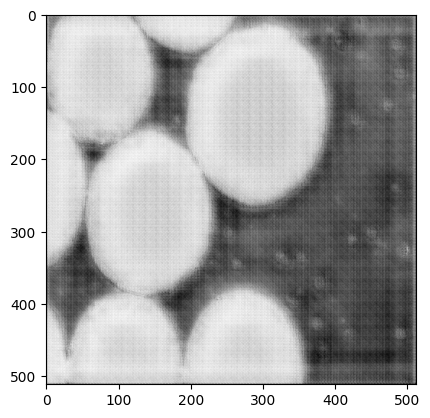

In [19]:
# DigitalSreeni
plt.imshow(pred[0], cmap = "gray")

In [20]:
ex_pred = cv2.normalize(pred[0], None, 0, 255, cv2.NORM_MINMAX)
ex_pred = ex_pred.astype(np.uint8)

In [21]:
_, thresh = cv2.threshold(ex_pred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

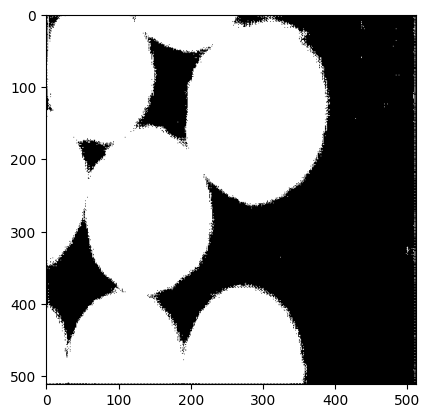

In [22]:
plt.imshow(thresh, cmap = "grey")

In [23]:
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 6)

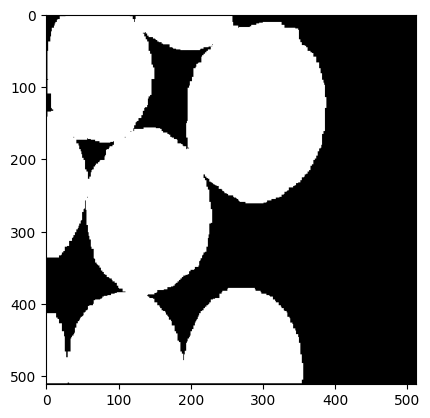

In [24]:
plt.imshow(opening, cmap = "grey")

In [25]:
sure_bg = cv2.dilate(opening, kernel, iterations = 10)

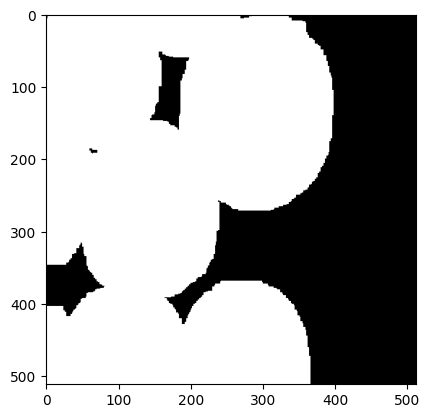

In [26]:
plt.imshow(sure_bg, cmap = "grey")

In [27]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

In [28]:
_, sure_fg = cv2.threshold(dist_transform, 0.25*dist_transform.max(), 255, 0)

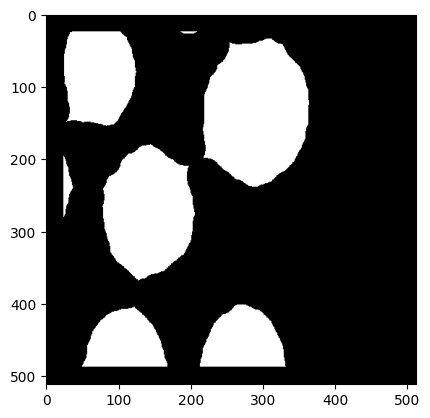

In [29]:
plt.imshow(sure_fg, cmap = "grey")

In [30]:
sure_fg = np.uint8(sure_fg)
unk = cv2.subtract(sure_bg, sure_fg)

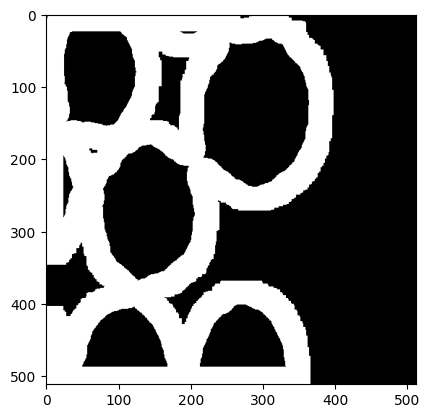

In [31]:
plt.imshow(unk, cmap = "grey")

In [32]:
_, markers = cv2.connectedComponents(sure_fg)

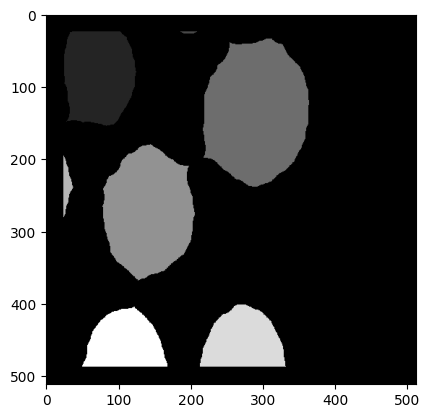

In [33]:
plt.imshow(markers, cmap = "grey")

In [34]:
markers = markers + 10

In [35]:
#Mark the unknown region with 0
markers[unk == 255] = 0

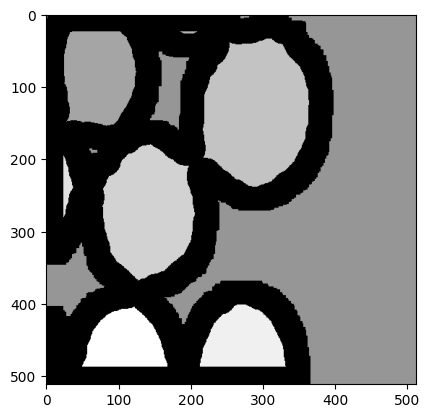

In [36]:
plt.imshow(markers, cmap = 'gray')

In [37]:
ex_image = test_images[0].astype(np.uint8)

In [38]:
markers = cv2.watershed(ex_image,markers)

In [39]:
ex_image[markers == -1] = [0,0,255]

In [40]:
ex_image_2 = skimage.color.label2rgb(markers, bg_label = 0)

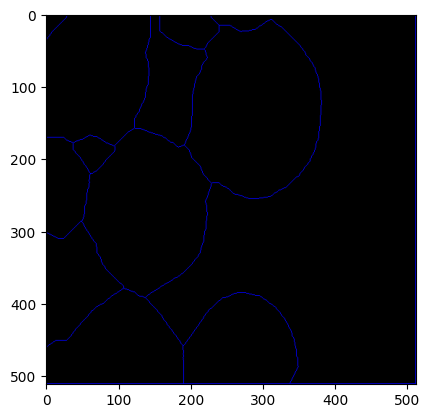

In [41]:
plt.imshow(ex_image)

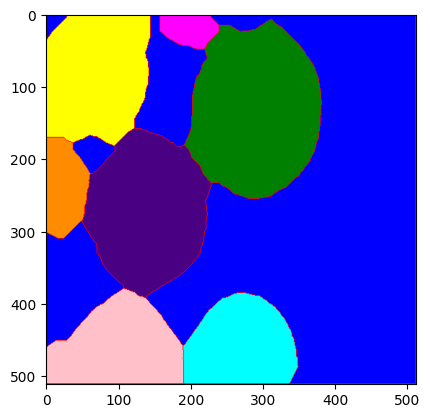

In [42]:
plt.imshow(ex_image_2)

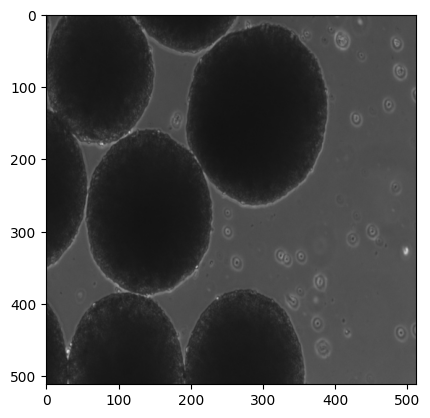

In [43]:
plt.imshow(test_images[0])

In [47]:
ex_image3 = cv2.cvtColor(test_images[0], cv2.COLOR_BGR2GRAY)

In [66]:
properties = ["label", "area", "centroid"]

In [67]:
props = skimage.measure.regionprops_table(markers, intensity_image = ex_image3, properties = properties)

In [68]:
df = pd.DataFrame(props)

In [69]:
print(df)

   label      area  centroid-0  centroid-1
0     10  128744.0  268.467882  338.843752
1     11   22586.0   85.059772   69.496591
2     12    2964.0   20.613698  197.910594
3     13   34898.0  133.591495  288.569717
4     14   28861.0  272.512907  139.797824
5     15    6531.0  239.440361   25.500842
6     16   15750.0  457.047746  269.409016
7     17   17683.0  460.097551   99.933552


Text(0.5, 1.0, 'Labeled Image with Region Properties')

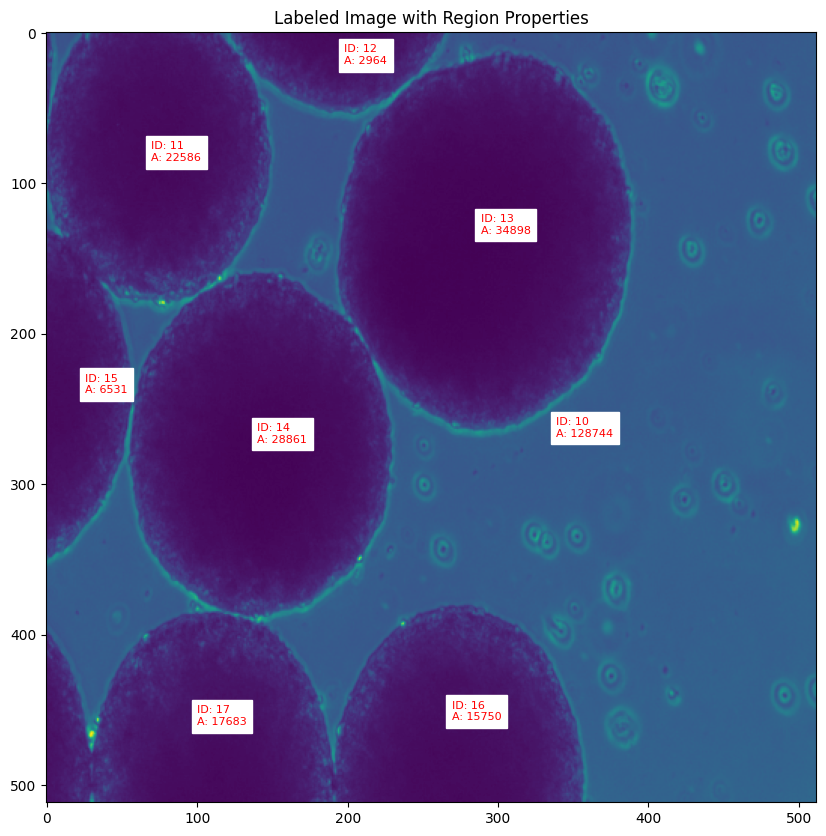

In [70]:
fig, ax = plt.subplots(figsize=(10, 10))

for _, row in df.iterrows():
    # Extract label, centroid, and area from the DataFrame
    label = row["label"]
    cy, cx = row["centroid-0"], row["centroid-1"]  # Centroid coordinates
    area = row["area"]

    # Annotate the label and area
    ax.text(
        cx, cy,
        f"ID: {int(label)}\nA: {int(area)}",
        color="red",
        fontsize=8,
        backgroundcolor="white"
    )

# Display
ax.imshow(ex_image3)
plt.title("Labeled Image with Region Properties")